## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**Vulcan Fossil Fuel CO₂ Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/vulcan-ffco2-yeargrid-v4_User_Notebook_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**:  Contiguous United States
- **Spatial resolution**: 1 km x 1 km
- **Temporal extent**: 2010 - 2021
- **Temporal resolution**: Annual
- **Unit**: Metric tons of carbon dioxide per 1 km x 1 km grid cell per year
- **Utility**: Climate Research

For more, visit the [Vulcan Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/vulcan-ffco2-yeargrid-v4) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Vulcan Fossil Fuel CO₂ Emissions Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The Vulcan version 4.0 data product represents total carbon dioxide (CO2) emissions resulting from the combustion of fossil fuel (ff) for the contiguous United States and District of Columbia. Referred to as ffCO2, the emissions from Vulcan are also categorized into 10 source sectors including; airports, cement production, commercial marine vessels, commercial, power plants, industrial, non-road, on-road, residential and railroads. Data are gridded annually on a 1-km grid for the years 2010 to 2021. These data are annual sums of hourly estimates. Shown is the estimated total annual ffCO2 for the United States, as well as the estimated total annual ffCO2 per sector.

For more information regarding this dataset, please visit the [Vulcan Fossil Fuel CO₂ Emissions, Version 4](https://earth.gov/ghgcenter/data-catalog/vulcan-ffco2-yeargrid-v4) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt
from stats_module import generate_stats, clean_stats, display_stats

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4. 
collection_name = "vulcan-ffco2-yeargrid-v4"

Next, you will examine the contents of the `collection` under the `temporal` variable, we see that the data is available from January 2010 to December 2021. By looking at the `dashboard:time density`, you observe that the data is periodic with year time density.

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=vulcan-ffco2-yeargrid-v4>

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 12 items


In [5]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=vulcan-ffco2-yeargrid-v4-2021>

## Visual Comparison Across Time Periods

You will now explore changes in methane emissions at a given location and time. You will visualize the outputs on a map using `folium`.


In [6]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:4]: item for item in collection.get_items()}

asset_name = "total-co2"

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. We will do this twice, once for 2021 and again for 2010, so that we can visualize each event independently.

In [7]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "spectral_r" 

# Make a GET request to retrieve information for the date mentioned below
first_date = items["2021"]

# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id

object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 272530.15625, 'min': 1.7858106104995386e-07}


In [8]:
# Make a GET request to retrieve information for the date mentioned below
month1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150"
).json()

# Print the properties of the retrieved granule to the console
month1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

In [9]:
# Make a GET request to retrieve information for date mentioned below
second_date = items["2010"]

# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

object = second_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

month2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150"
).json()

# Print the properties of the retrieved granule to the console
month2_tile

{'max': 371624.03125, 'min': 1.898683592571615e-07}


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2010/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

## Map Out Selected Tiles

In [10]:
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_2021 = TileLayer(
    tiles=month1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2021 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2021.add_to(map_.m1)

map_layer_2010 = TileLayer(
    tiles=month2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2010 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2010.add_to(map_.m2)

map_

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [11]:
# Create a polygon for the area of interest (aoi)
sanfrancisco_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-122.52709933248232, 37.816224913955665],
                [-122.52709933248232,37.69714432421999],
                [-122.3493837208909,37.69714432421999],
                [-122.3493837208909,37.816224913955665],
                [-122.52709933248232,37.816224913955665]            
            ]
        ],
        "type": "Polygon",
    },
}

In [12]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 12 items


In [13]:
# Examine the first item in the collection
items[0]

{'id': 'vulcan-ffco2-yeargrid-v4-2021',
 'bbox': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/map?assets=total-co2&rescale=0%2C500&colormap_name=spectral_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, sanfrancisco_aoi,asset_name) for item in items]

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [15]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 25.978267669677734,
   'max': 18724.814453125,
   'mean': 3894.744873046875,
   'count': 184.8000030517578,
   'sum': 719748.875,
   'std': 3835.0934799558668,
   'median': 3031.908447265625,
   'majority': 495.4798583984375,
   'minority': 25.978267669677734,
   'unique': 162.0,
   'histogram': [[92, 36, 28, 13, 15, 11, 2, 4, 2, 1],
    [25.978267669677734,
     1895.86181640625,
     3765.745361328125,
     5635.62841796875,
     7505.51220703125,
     9375.396484375,
     11245.279296875,
     13115.1630859375,
     14985.046875,
     16854.9296875,
     18724.814453125]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 204.0,
   'percentile_2': 65.28433990478516,
   'percentile_98': 14337.2021484375}},
 'datetime': '2021-01-01T00:00:00+00:00'}

In [16]:
# Apply the generated function on the stats data
df = clean_stats(stats)
df = df.sort_values("datetime")

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
11,2010-01-01T00:00:00+00:00,30.241028,69106.171875,4956.730957,184.800003,916003.8750,6627.936330,3750.835205,446.106964,30.241028,163.0,"[[156, 39, 7, 1, 0, 0, 0, 0, 0, 1], [30.241027...",100.0,0.0,204.0,82.460045,19362.939453,2010-01-01 00:00:00+00:00
10,2011-01-01T00:00:00+00:00,31.349745,22492.718750,4625.165527,184.800003,854730.5625,4588.576032,3712.677246,567.197998,31.349745,162.0,"[[95, 32, 30, 14, 16, 9, 2, 3, 1, 2], [31.3497...",100.0,0.0,204.0,82.258919,17496.175781,2011-01-01 00:00:00+00:00
9,2012-01-01T00:00:00+00:00,31.183622,22096.847656,4502.496094,184.800003,832061.2500,4477.353013,3627.813965,574.196045,31.183622,162.0,"[[96, 31, 30, 16, 14, 8, 3, 3, 1, 2], [31.1836...",100.0,0.0,204.0,80.988640,17163.974609,2012-01-01 00:00:00+00:00
8,2013-01-01T00:00:00+00:00,30.872309,22365.929688,4643.817383,184.800003,858177.5000,4702.375995,3659.211426,572.865051,30.872309,162.0,"[[96, 30, 30, 17, 13, 8, 3, 3, 1, 3], [30.8723...",100.0,0.0,204.0,79.855156,18730.273438,2013-01-01 00:00:00+00:00
7,2014-01-01T00:00:00+00:00,31.891571,21452.687500,4405.563965,184.800003,814148.2500,4504.944839,3359.792480,564.426819,31.891571,162.0,"[[96, 32, 29, 16, 12, 8, 4, 4, 0, 3], [31.8915...",100.0,0.0,204.0,82.956650,17018.300781,2014-01-01 00:00:00+00:00


## Time-Series Analysis
We can now explore the total fossil fuel emission time series (2010 -2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

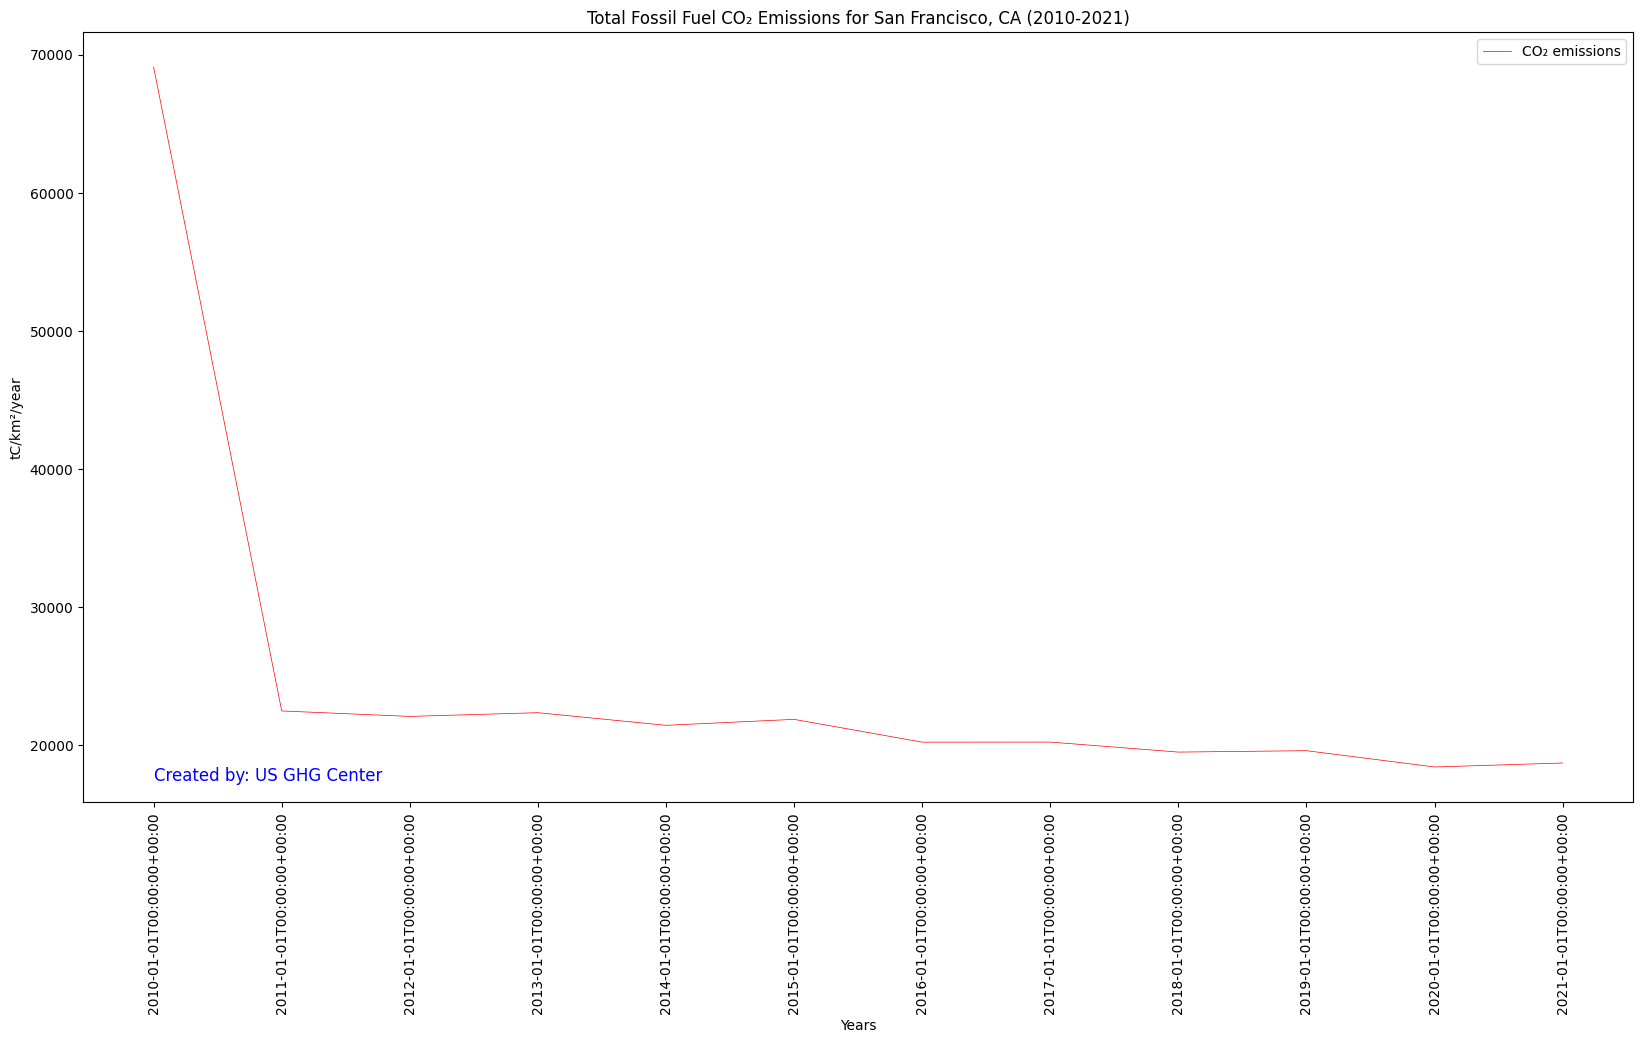

In [17]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tC/km²/year")
plt.xticks(rotation = 90)

# Insert title for the plot
plt.title("Total Fossil Fuel CO₂ Emissions for San Francisco, CA (2010-2021)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text
    # Text to be displayed
    "Created by: US GHG Center",      #example text            
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4 dataset.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the total fossil fuel CO₂ emissions for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).